# Prepare a Training Data Set for ML

The main goal of this tutorial is to: Extract data from **multiple** STAC collections only at the **specified locations** as a **time series**.

As an example use case we are going to...
1. Get Station Data:
    - Download point data time series with a measured variable (e.g. snow depth)
    - Preprocess it to be used with EO Data
2. Get EO Data:
    - Query a STAC catalog
    - Get acquisitions for the points in the relevant time frame (temporal, spatial)
    - Get acquisitions from different collections
3. Prepare EO Data:
    - Load the found items into one data cube, by only loading the relevant geometry
    - Homogenize the datacube to a common temporal and spatial resolution
    - Add new information to the data cube: Calculate the NDSI (*ideally the collections should be radiometrically harmonized, e.g. [sen2like](https://github.com/senbox-org/sen2like), we are not doing this for this tutorial*)
    - Evaluate the gain in time steps 
4. Combine EO and Station Data:
    - Convert the data cube and the station measurements
    - Use a format that can be easily used for machine learning
5. Apply Machine Learning
    - Regression model to predict snow depth (this is exemplatory, not scientifically valid)
6. Weather Data
    - Compare to snow depth from ERA5 Land 

This tutorial should serve as guidance on how to extract data from multiple sources from STAC catalogs and use them in further workflows.
There are many more applications that could be covered. The next step could be to add more predictors and do a multivariate regression, taking into account more factors like elevation, aspect, temperature, etc.

Things to consider
- sparse xarray data cubes
- xvec


<img src="sketch_ws_prepml.png" width="600">

## Environment

This notebook needs a custom environment on terrabyte to run. Run the `micromamba install ...` cell below. Then close the session. Start a new jupyter session from the [terrabyte portal](https://portal.terrabyte.lrz.de/) where you specify the name (*prepml* in this example) of the newly created environment in the *custom environment field* (you have to type it there the first time you use it, then it will be available from the dropdown list above).  

In [1]:
# !micromamba create -y -n prepml requests numpy pandas geopandas xarray xvec rioxarray shapely odc-stac odc-geo pystac-client dask folium branca tensorflow seaborn libgdal libgdal-jp2openjpeg zarr jupyter jupyter-server-proxy

In [2]:
import os
import time
import socket
import io
import zipfile
from datetime import datetime, timezone

import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import xarray
import xvec
import rioxarray
from shapely.geometry import box, shape
from odc import stac as odc_stac
from odc.geo import geobox
from pystac_client import Client as pystacclient
from pystac.extensions.raster import RasterExtension
import tensorflow as tf
import seaborn as sns
import dask
from dask.distributed import Client

import folium
import folium.plugins as folium_plugins
import branca.colormap as cm


2024-12-04 16:52:19.150971: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 16:52:19.188442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Get Station data

### 1.1 Download station data 

Download station data time series. We are going to use monthly snow depth measurements in South Tyrol. They have been prepared, gapfilled and made available via the ClirSnow project.

In [3]:
# set url
url = 'https://zenodo.org/records/5109574/files/meta_all.csv?download=1'
filename = url.split('/')[-1]
filename = filename.split('?')[0]

# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Save the file locally
    with open(filename, 'wb') as file:
        file.write(response.content)
    print("File downloaded and saved successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded and saved successfully.


In [4]:
sd_meta = pd.read_csv(filename)
sd_meta.head()

,Provider,Name,Longitude,Latitude,Elevation,HN_year_start,HN_year_end,HS_year_start,HS_year_end
0,AT_HZB,Absdorf,15.976667,48.401667,182.0,1970.0,2016.0,1970.0,2016.0
1,AT_HZB,Ach_Burghausen,12.846389,48.148889,473.0,1990.0,2016.0,1990.0,2016.0
2,AT_HZB,Admont,14.457222,47.567778,700.0,1970.0,2016.0,1970.0,2016.0
3,AT_HZB,Afritz,13.795556,46.727500,715.0,1970.0,2016.0,1970.0,2016.0
4,AT_HZB,Alberschwende,9.849167,47.458333,717.0,1982.0,2016.0,1982.0,2016.0


In [5]:
# set url
url = 'https://zenodo.org/records/5109574/files/data_monthly_IT_BZ.zip?download=1'
filename = url.split('/')[-1]
filename = filename.split('?')[0]

# Send a GET request to download the file
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the downloaded file as a zip file
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        # Extract all contents into the current directory
        zip_ref.extractall()
    print("File downloaded and extracted successfully.")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded and extracted successfully.


In [6]:
# read it into memory
filename = filename.split('.')[0] + '.csv'
sd_mnth = pd.read_csv(filename)
sd_mnth.head()

,Name,year,month,HNsum,HSmean,HSmax,SCD1,SCD1gt,SCD10,SCD20,...,HSmean_gapfill,frac_gapfilled,HSmax_gapfill,SCD1_gapfill,SCD1gt_gapfill,SCD10_gapfill,SCD20_gapfill,SCD30_gapfill,SCD50_gapfill,SCD100_gapfill
0,Alliz_Maso_Strimo_Osservatore,1991,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.612903,1.0,54.0,31.0,31.0,31.0,31.0,31.0,6.0,0.0
1,Alliz_Maso_Strimo_Osservatore,1991,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.392857,1.0,48.0,28.0,28.0,28.0,28.0,28.0,0.0,0.0
2,Alliz_Maso_Strimo_Osservatore,1991,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.677419,1.0,29.0,28.0,28.0,21.0,13.0,0.0,0.0,0.0
3,Alliz_Maso_Strimo_Osservatore,1991,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.366667,1.0,6.0,12.0,8.0,0.0,0.0,0.0,0.0,0.0
4,Alliz_Maso_Strimo_Osservatore,1991,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.032258,1.0,8.0,9.0,6.0,0.0,0.0,0.0,0.0,0.0


### 1.2 Prepare station data

Filter the metadata to keep only stations form the province of South Tyrol having values between 2000 and 2019. 

In [7]:
start = 2000
end = 2019
sd_meta = sd_meta[(sd_meta['Provider'] == 'IT_BZ') & (sd_meta['HS_year_start'] <= start) & (sd_meta['HS_year_end'] >= end)]
sd_meta = sd_meta[['Name', 'Longitude', 'Latitude', 'Elevation']]

Select relevant columns.

In [8]:
sd_mnth = sd_mnth[['Name', 'year', 'month', 'HSmean_gapfill']]
sd_mnth = sd_mnth[sd_mnth['year'].between(start, end)]

And join the meta data (geographical information, ...).

In [9]:
sd = pd.merge(sd_meta, sd_mnth, on='Name', how='inner')

This is what our station data looks like now. The meta data combined with the measurements.

In [10]:
sd.head()

,Name,Longitude,Latitude,Elevation,year,month,HSmean_gapfill
0,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,1,21.258065
1,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,2,18.103448
2,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,3,7.935484
3,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,4,0.033333
4,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,2000,5,0.000000


Turn snow depth time series into a geodataframe (we also do it for the metadata for plotting the locations).

In [11]:
sd = gpd.GeoDataFrame(sd, geometry=gpd.points_from_xy(sd.Longitude, sd.Latitude), crs="EPSG:4326")
sd_meta = gpd.GeoDataFrame(sd_meta, geometry=gpd.points_from_xy(sd_meta.Longitude, sd_meta.Latitude), crs="EPSG:4326")

Create a buffer around the points for extracting more than just one pixel.

In [12]:
sd_meta = sd_meta.to_crs(3035) # LAEA Europe
sd_meta['geometry'] = sd_meta['geometry'].buffer(distance=200, cap_style='square') # square
sd_meta = sd_meta.to_crs(4326) # Back to 4326

Look at the distribution of the stations and the buffers on a map.

In [13]:
colormap = cm.linear.viridis.scale(round(sd_meta['Elevation'].min(), -2), round(sd_meta['Elevation'].max(), -2))
colormap.caption = 'Elevation m'

m = folium.Map(tiles="OpenStreetMap", zoom_start=9)

folium.GeoJson(
    sd_meta,
    name="Snow Depth Stations Buffer",
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['Elevation']),
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(fields=["Name", "Elevation"]),
).add_to(m)

folium.GeoJson(
    sd_meta.geometry.centroid,
    name="Snow Depth Stations",
).add_to(m)

colormap.add_to(m)
m.fit_bounds(m.get_bounds())
m

/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_140490/4200203065.py:19: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sd_meta.geometry.centroid,


Create a bounding box columns for querrying the STAC catalog.

In [14]:
sd_meta = pd.concat([sd_meta, sd_meta.bounds], axis=1)

## 2. Get EO Data: The terrabyte STAC Catalog

### 2.1 Discover the STAC Catalog

List all available collections

In [15]:
catalog_url = 'https://stac.terrabyte.lrz.de/public/api'
catalog = pystacclient.open(catalog_url)
collections = list(catalog.get_all_collections())
for collection in collections:
    print(f"{collection.id} | {collection.title} | {collection.extent.temporal.intervals[0][0].year} - {collection.extent.temporal.intervals[0][1].year}") 


modis-09gq-061 | MOD09GQ.061 & MYD09GQ.061: MODIS Surface Reflectance Daily (250m) | 2000 - 2024
sentinel-1-slc | Sentinel-1 SLC Level-1 | 2016 - 2024
viirs-13a1-001 | VNP13A1.001: VIIRS Vegetation Indices 16-Day (500m) | 2012 - 2024
sentinel-1-nrb | Sentinel-1 Normalized Radar Backscatter (NRB) | 2015 - 2024
modis-13q1-061 | MOD13Q1.061 & MYD13Q1.061: MODIS Vegetation Indices 16-Day (250m) | 2000 - 2024
sentinel-2-c1-l2a | Sentinel-2 Collection 1 Level-2A | 2015 - 2024
modis-13a2-061 | MOD13A2.061 & MYD13A2.061: MODIS Vegetation Indices 16-Day (1km) | 2000 - 2024
sentinel-3-olci-l1-efr | Sentinel-3 OLCI Level-1 EFR | 2016 - 2024
viirs-09ga-001 | VNP09GA.001: VIIRS/NPP Surface Reflectance Daily L2GD 500m and 1km | 2013 - 2024
landsat-tm-c2-l2 | Landsat 4-5 TM Collection 2 Level-2 | 1982 - 2012
landsat-etm-c2-l2 | Landsat 7 ETM+ Collection 2 Level-2 | 1999 - 2024
modis-10a1-061 | MOD10A1.061 & MYD10A1.061: MODIS Snow Cover Daily | 2000 - 2024
cop-dem-glo-90 | Copernicus DEM GLO-90 | 202

Check the bandnames for S2 C1 L2A, the LS collections

In [16]:
collections[15] # TODO: how can i filter by name here?

<CollectionClient id=sentinel-2-c1-l1c>

## 2.2 Query data from the STAC catalog

### 2.2.1 Query a single station

Let's define the parameters we want to use for both collections.

In [17]:
max_cloud_cover = 25

query = {
    'eo:cloud_cover': {
        "gte": 0,
        "lte": max_cloud_cover
    }
}

start = '2000-01-01T00:00:00Z'
end = '2019-12-31T23:59:59Z'

bands = ['swir16', 'green'] # luckily the bands have the same names across multiple collections. That's not always the case.

Search Sentinel-2 for one specific station. The first station in the list.

In [18]:
%%time
collection = ['sentinel-2-c1-l2a']
bbox = [sd_meta.minx.iloc[0], sd_meta.miny.iloc[0], sd_meta.maxx.iloc[0], sd_meta.maxy.iloc[0]] # first station in list

search = catalog.search(collections=collection,
                        bbox=bbox,
                        datetime=[start, end],
                        query=query)
items = list(search.items()) # TODO: Is this still the correct way to do it?

print(f'Found {len(items)} Scenes') 

Found 84 Scenes
CPU times: user 79.4 ms, sys: 5.79 ms, total: 85.2 ms
Wall time: 8.81 s


Inspect the search results. Full tiles are returned with their according metadata.

In [19]:
items[0]

<Item id=S2A_MSIL2A_20191230T101421_N0500_R022_T32TQT_20230619T224243>

Search Sentinel-2 and all Landsat collections for the specified parameters and the same specific station.

In [20]:
%%time
collection = ['landsat-ot-c2-l2', 'landsat-etm-c2-l2', 'landsat-tm-c2-l2', 'sentinel-2-c1-l2a'] # searching for each collection seperately is more performant for larger requests!

search = catalog.search(collections=collection,
                        bbox=bbox,
                        datetime=[start, end],
                        query=query)
items = list(search.items()) # TODO: Is this still the correct way to do it?

print(f'Found {len(items)} Scenes') 

Found 1092 Scenes
CPU times: user 1.21 s, sys: 77.8 ms, total: 1.29 s
Wall time: 54.5 s


This search, explicitly adressing the collections is more effective!

In [21]:
%%time
collection = ['landsat-ot-c2-l2', 'landsat-etm-c2-l2', 'landsat-tm-c2-l2', 'sentinel-2-c1-l2a']

for col in collection: 
    search = catalog.search(collections=col,
                            bbox=bbox,
                            datetime=[start, end],
                            query=query)
    items = list(search.items()) # TODO: Is this still the correct way to do it?
    print(f'Collection: {col}. Found {len(items)} Scenes') 

Collection: landsat-ot-c2-l2. Found 154 Scenes
Collection: landsat-etm-c2-l2. Found 568 Scenes
Collection: landsat-tm-c2-l2. Found 286 Scenes
Collection: sentinel-2-c1-l2a. Found 84 Scenes
CPU times: user 1.27 s, sys: 81.2 ms, total: 1.35 s
Wall time: 17.5 s


### 2.2.2 Query multiple stations

Define a function to use to iterate over all stations. bbox is the variable object in this function, it is extracted from each row of the station list.

In [22]:
def query_stac(row, collection):
    bbox = [row.minx, row.miny, row.maxx, row.maxy]
    search = catalog.search(collections=collection,
                            bbox=bbox,
                            datetime=[start, end],
                            query=query)
    items = list(search.items())
    print(f"Name: {row['Name']}, Items: {len(items)}")
    return items

The function is applied to the station metadata geodataframe, where we had stored the buffers around the stations. The result is a list with all found STAC items for each of the stations.

In [23]:
%%time
collection = ['sentinel-2-c1-l2a']
items_list_s2 = sd_meta.apply(query_stac, args = collection, axis=1)

Name: Anterselva_di_Mezzo_Osservatore, Items: 84
Name: Bronzolo_Osservatore, Items: 26
Name: Diga_di_Gioveretto_Osservatore, Items: 26
Name: Diga_di_Neves_Osservatore, Items: 119
Name: Diga_di_Valdaora_Osservatore, Items: 14
Name: Diga_di_Vizze_Osservatore, Items: 162
Name: Diga_di_Zoccolo_Osservatore, Items: 26
Name: Fie_allo_Sciliar_Osservatore, Items: 26
Name: Fontana_Bianca, Items: 26
Name: Fortezza_Osservatore, Items: 50
Name: Fundres_Osservatore, Items: 313
Name: La_Villa_in_Badia_Osservatore, Items: 14
Name: Lago_Verde_Osservatore, Items: 26
Name: Lazfons_Osservatore, Items: 26
Name: Longiaru_Osservatore, Items: 14
Name: Luson_Osservatore, Items: 14
Name: Maia_Alta_Osservatore, Items: 26
Name: Mazia_Osservatore, Items: 26
Name: Melago_Osservatore, Items: 26
Name: Meltina_Osservatore, Items: 26
Name: Molini_di_Tures_Osservatore, Items: 84
Name: Ortisei_Osservatore, Items: 29
Name: Pennes_Osservatore, Items: 26
Name: Plata_Osservatore, Items: 26
Name: Racines_di_Dentro_Osservatore

### 2.2.3 Excursion: Use geometry of interest directly in search
If your point/vector data is spread out across the globe, with many itmes in between the geometries, it is better to use the geometry explicitly in the STAC search and not the bounding box. In this way you will only get the tiles you are interested in.

If your point/vector data is close to one another, with little items in between the geometries, it is better to use the bounding box of your geometries in the STAC search. In this way you will not duplicate any items in your search. This is what we will do know.

### 2.2.4 Query full bounding box

We pass the full bounding box of our station network to the search.

In [24]:
%%time
collection = 'sentinel-2-c1-l2a'
bbox = [sd_meta.minx.min(), sd_meta.miny.min(), sd_meta.maxx.max(), sd_meta.maxy.max()] # all stations

search = catalog.search(collections=collection,
                        bbox=bbox,
                        datetime=[start, end],
                        query=query)
items_s2 = list(search.items()) # TODO: Is this still the correct way to do it?
print(f'Collection: {collection}. Found {len(items_s2)} Scenes') 

Collection: sentinel-2-c1-l2a. Found 313 Scenes
CPU times: user 240 ms, sys: 9.53 ms, total: 250 ms
Wall time: 3.3 s


In [25]:
%%time
collection = ['landsat-ot-c2-l2', 'landsat-etm-c2-l2', 'landsat-tm-c2-l2']

items_ls = []
for col in collection: 
    search = catalog.search(collections=col,
                            bbox=bbox,
                            datetime=[start, end],
                            query=query)
    items = list(search.items()) # TODO: Is this still the correct way to do it?
    items_ls.append(items)
    print(f'Collection: {col}. Found {len(items)} Scenes')

# currently we have a list with 3 entries, let's flatten it
items_ls = [item for sublist in items_ls for item in sublist]

Collection: landsat-ot-c2-l2. Found 302 Scenes
Collection: landsat-etm-c2-l2. Found 876 Scenes
Collection: landsat-tm-c2-l2. Found 434 Scenes
CPU times: user 2.01 s, sys: 94.4 ms, total: 2.11 s
Wall time: 28.6 s


Let's plot a some items in relation to a station. It becomes clear that loading all of this data should be avoided if possible!

In [26]:
map = folium.Map()
layer_control = folium.LayerControl(position='topright', collapsed=True)

tile_s2 = shape(items_s2[0].geometry)
tile_s2 = gpd.GeoDataFrame([{'geometry': tile_s2}], crs="EPSG:4326")
tile_s2 = folium.GeoJson(tile_s2.to_json(), name="S2", style_function=lambda x: {"fillColor": "blue"})

tile_ls = shape(items_ls[0].geometry)
tile_ls = gpd.GeoDataFrame([{'geometry': tile_ls}], crs="EPSG:4326")
tile_ls = folium.GeoJson(tile_ls.to_json(), name="LS", style_function=lambda x: {"fillColor": "green"})

aoi = box(*bbox)
aoi = gpd.GeoDataFrame({"geometry": [aoi]}, crs="EPSG:4326")
aoi = folium.GeoJson(aoi.to_json(), name="aoi", style_function=lambda x: {"fillColor": "white"})

station = box(*[sd_meta.minx.iloc[0], sd_meta.miny.iloc[0], sd_meta.maxx.iloc[0], sd_meta.maxy.iloc[0]])
station = gpd.GeoDataFrame({"geometry": [station]}, crs="EPSG:4326")
station_mark = station.geometry.centroid
station = folium.GeoJson(station.to_json(), name="Station", style_function=lambda x: {"fillColor": "red"})

station_mark = folium.GeoJson(station_mark,name="Station Marker")

tile_s2.add_to(map)
tile_ls.add_to(map)
station.add_to(map)
aoi.add_to(map)
station_mark.add_to(map)
layer_control.add_to(map)
map.fit_bounds(map.get_bounds())
map

/dss/dsstbyfs02/scratch/06/di38laz/di38laz/ipykernel_140490/1562082567.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  station_mark = station.geometry.centroid


## 3. Starting a Dask Cluster

Here we are starting the dask client for scaling the computation to the available resources.
Once started, a link to the dask dashboard will be shown which will display details on the dask computation status.
This should be done **before** the first calculation on xarray objects takes place!

In [27]:
dir_out = '~/ws_prepml'
dask_tmpdir = os.path.join(dir_out, 'scratch', 'localCluster')
# from testins running without threads is the faster option 
dask_threads = 1

In [28]:
host = os.getenv('host')
jl_port = os.getenv('port')
#create to URL to point to the jupyter-server-proxy
dask_url = f'https://portal.terrabyte.lrz.de/node/{host}/{jl_port}'+'/proxy/{port}/status' 
#dask will insert the final port choosen by the Cluster 

dask.config.set({'temporary_directory': dask_tmpdir,
                 'distributed.dashboard.link': dask_url})

#some settings to increase network timeouts and allow the dashboard to plot larger graphs
#dask.config.set({'distributed.comm.timeouts.tcp': '180s',
#                 'distributed.comm.timeouts.connect': '120s',
#                 'distributed.dashboard.graph-max-items': 55000,
#                 'distributed.deploy.lost-worker-timeout': '90s',
#                 'distributed.scheduler.allowed-failures': 180,
#                 })

#we set the dashboard address for dask to choose a free random port, so there is no error with multiple dasks running on same node 
client = Client(threads_per_worker=dask_threads, dashboard_address="127.0.0.1:0")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/59650/proxy/41633/status,
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/59650/proxy/41633/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35487,Workers: 4
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/59650/proxy/41633/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:44755,Total threads: 1
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/59650/proxy/41767/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:36347,


## 4. Prototyping

**Testing the workflow on a small subset of the data**. Before the workflow is mature it needs to be tested. This should be done on a small subset of the data set to: reduce processing time, save resources, get a feeling for the value ranges etc. Let's develop the workflow on a single station before expanding to all of them.

### 4.1 Reduce amount of data for quick prototyping
First, some tweaks to reduce the amount of data.

In [29]:
# choose which collection to prototype for...
prototype = "s2"
#prototype = "ls"

# choose the timerange for prototyping
start_date = datetime(2017, 1, 1, tzinfo=timezone.utc)
end_date = datetime(2018, 1, 1, tzinfo=timezone.utc)

# assign the values according to the chosen collection
if prototype == "s2":
    print("prototype for s2")
    items_tst = items_s2
    scale = RasterExtension.ext(items_tst[0].assets["B03"]).bands[0].scale # 0.0001; it is constant across the relevant bands and timesteps
    offset = RasterExtension.ext(items_tst[0].assets["B03"]).bands[0].offset # -0.1; it is constant across the relevant bands and timesteps
elif prototype == "ls":
    print("prototype for ls")
    items_tst = items_ls
    scale = RasterExtension.ext(items_tst[0].assets["B03"]).bands[0].scale # 2.75e-05; it is constant across the relevant bands and timesteps
    offset = RasterExtension.ext(items_tst[0].assets["B03"]).bands[0].offset # -0.2; it is constant across the relevant bands and timesteps
else:
    raise ValueError("prototype must be s2 or ls.")

print(f"scale: {scale}, offset: {offset}")

# reduce timesteps
items_tst = [
    item for item in items_tst
    if start_date <= item.datetime <= end_date
]

# aoi (the buffer around one single station)
aoi_tst = sd_meta.iloc[0]


prototype for s2
scale: 0.0001, offset: -0.1


Defining a reduced data cube (**lazily - nothing is loaded so far**)

In [30]:
cube = odc_stac.load(items_tst,
                     geopolygon=aoi_tst.geometry,
                     groupby='solar_day',
                     chunks={"x": 128, "y": 128, "time": -1}, # maybe add a time chunk?
                     bands=bands
)
cube

<xarray.Dataset> Size: 263kB
Dimensions:      (y: 41, x: 42, time: 38)
Coordinates:
  * y            (y) float64 328B 5.195e+06 5.195e+06 ... 5.194e+06 5.194e+06
  * x            (x) float64 336B 7.361e+05 7.362e+05 ... 7.365e+05 7.366e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 304B 2017-01-24T10:13:11.026000 ... 20...
Data variables:
    swir16       (time, y, x) uint16 131kB dask.array<chunksize=(38, 41, 42), meta=np.ndarray>
    green        (time, y, x) uint16 131kB dask.array<chunksize=(38, 41, 42), meta=np.ndarray>

### 4.2 Test the processing steps
Scale, aggregate to monthly values (maximum value composite), calculate ndsi. **Still lazy.**

In [31]:
cube = cube * scale + offset
cube = cube.resample(time="1ME").max().chunk(chunks={'time': -1})
cube["ndsi"] = (cube.green - cube.swir16) / (cube.green + cube.swir16)
#cube = cube["ndsi"]


Load a couple of time steps to check the values! **Now data is loaded!**

In [32]:
%%time
tst = cube.isel(time = slice(0,5)).load()

CPU times: user 503 ms, sys: 81.9 ms, total: 585 ms
Wall time: 11.8 s


Plot the bands and the ndsi to check the values!

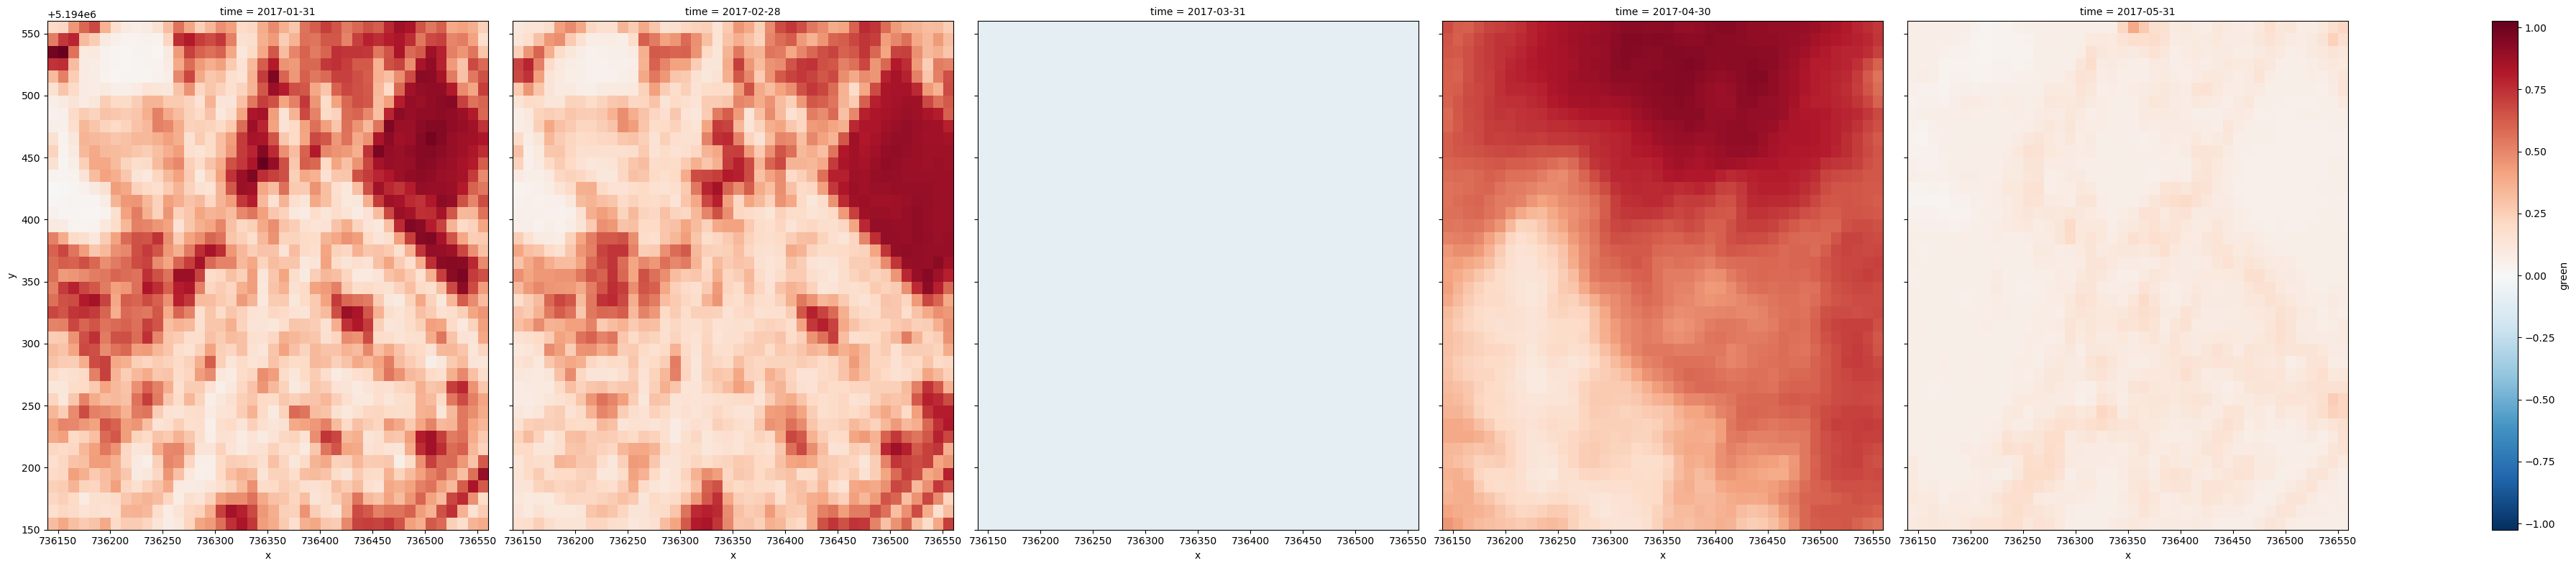

In [33]:
tst['green'].plot.imshow(col="time", size=8, aspect=1) # , vmin = -1, vmax = 1

Look at the values as well!

In [34]:
tst.isel(time = 2)

<xarray.Dataset> Size: 42kB
Dimensions:      (y: 41, x: 42)
Coordinates:
  * y            (y) float64 328B 5.195e+06 5.195e+06 ... 5.194e+06 5.194e+06
  * x            (x) float64 336B 7.361e+05 7.362e+05 ... 7.365e+05 7.366e+05
    spatial_ref  int32 4B 32632
    time         datetime64[ns] 8B 2017-03-31
Data variables:
    swir16       (y, x) float64 14kB -0.1 -0.1 -0.1 -0.1 ... -0.1 -0.1 -0.1 -0.1
    green        (y, x) float64 14kB -0.1 -0.1 -0.1 -0.1 ... -0.1 -0.1 -0.1 -0.1
    ndsi         (y, x) float64 14kB -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0

Aggregate the cube to spatially to get a time series for the whole period we chose. This is to check if the seasonality makes sense.

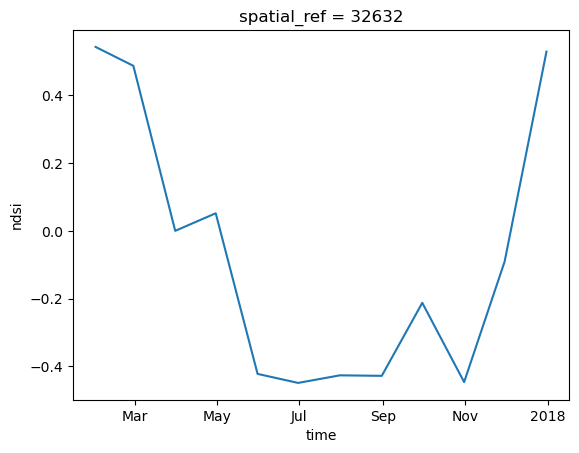

In [35]:
cube_ts = cube['ndsi'].mean(dim=["x", "y"])
cube_ts.plot()

### 4.3 Compare to station data
Get the snow depth data for the test station

In [36]:
aoi_tst

Name                           Anterselva_di_Mezzo_Osservatore
Longitude                                            12.100897
Latitude                                             46.860722
Elevation                                               1236.0
geometry     POLYGON ((12.103587999028658 46.86247066833042...
minx                                                 12.098205
miny                                                 46.858871
maxx                                                 12.103588
maxy                                                 46.862573
Name: 2508, dtype: object

Check what the actual measurements look like.

In [37]:
sd_mnth[(sd_mnth['Name']==aoi_tst.Name)].head()

,Name,year,month,HSmean_gapfill
1128,Anterselva_di_Mezzo_Osservatore,2000,1,21.258065
1129,Anterselva_di_Mezzo_Osservatore,2000,2,18.103448
1130,Anterselva_di_Mezzo_Osservatore,2000,3,7.935484
1131,Anterselva_di_Mezzo_Osservatore,2000,4,0.033333
1132,Anterselva_di_Mezzo_Osservatore,2000,5,0.000000


Add a time column in date format that matches the date format in the data cube.

In [38]:
sd_mnth['time'] = pd.to_datetime(sd_mnth['year'].astype(str) + '-' + sd_mnth['month'].astype(str)) + pd.offsets.MonthEnd(0)

Filter to the chosen time range and station.

In [39]:
sd_tst = sd_mnth[(sd_mnth['Name']==aoi_tst.Name) & 
    (sd_mnth['time']>=cube_ts.time.min().values) & 
    (sd_mnth['time']<=cube_ts.time.max().values)]
sd_tst.head()

,Name,year,month,HSmean_gapfill,time
1332,Anterselva_di_Mezzo_Osservatore,2017,1,4.483871,2017-01-31
1333,Anterselva_di_Mezzo_Osservatore,2017,2,5.071429,2017-02-28
1334,Anterselva_di_Mezzo_Osservatore,2017,3,0.677419,2017-03-31
1335,Anterselva_di_Mezzo_Osservatore,2017,4,0.200000,2017-04-30
1336,Anterselva_di_Mezzo_Osservatore,2017,5,0.096774,2017-05-31


Convert the ndsi time series to a data frame.

In [40]:
df_ts = cube_ts.to_dataframe()
df_ts.head()

,spatial_ref,ndsi
time,,
2017-01-31,32632,0.542521
2017-02-28,32632,0.486709
2017-03-31,32632,0.000000
2017-04-30,32632,0.051823
2017-05-31,32632,-0.421956


Join the two time series by date.

In [41]:
sd_tst = pd.merge(sd_tst, df_ts, on = "time")
sd_tst

,Name,year,month,HSmean_gapfill,time,spatial_ref,ndsi
0,Anterselva_di_Mezzo_Osservatore,2017,1,4.483871,2017-01-31,32632,0.542521
1,Anterselva_di_Mezzo_Osservatore,2017,2,5.071429,2017-02-28,32632,0.486709
2,Anterselva_di_Mezzo_Osservatore,2017,3,0.677419,2017-03-31,32632,0.000000
3,Anterselva_di_Mezzo_Osservatore,2017,4,0.200000,2017-04-30,32632,0.051823
4,Anterselva_di_Mezzo_Osservatore,2017,5,0.096774,2017-05-31,32632,-0.421956
5,Anterselva_di_Mezzo_Osservatore,2017,6,0.000000,2017-06-30,32632,-0.448616
6,Anterselva_di_Mezzo_Osservatore,2017,7,0.000000,2017-07-31,32632,-0.426197
7,Anterselva_di_Mezzo_Osservatore,2017,8,0.000000,2017-08-31,32632,-0.427736
8,Anterselva_di_Mezzo_Osservatore,2017,9,0.000000,2017-09-30,32632,-0.212356
9,Anterselva_di_Mezzo_Osservatore,2017,10,0.000000,2017-10-31,32632,-0.446130


Plot their relationship (as a time series and as a scatter plot).

Text(0, 0.5, 'NDSI')

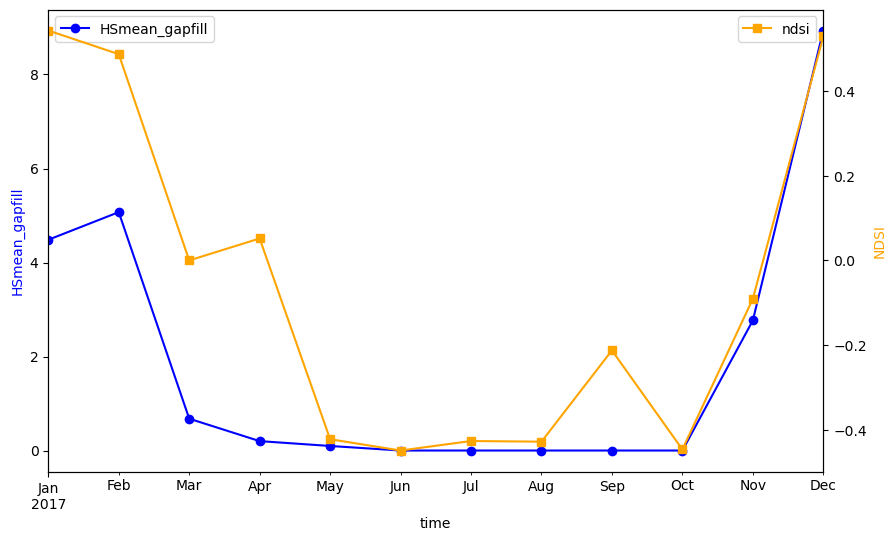

In [42]:
ax = sd_tst.plot(x="time", y="HSmean_gapfill", label="HSmean_gapfill", marker="o", color="blue", figsize=(10, 6))
ax.set_ylabel("HSmean_gapfill", color="blue")
ax.legend(loc="upper left")

ax2 = ax.twinx()
sd_tst.plot(x="time", y="ndsi", label="ndsi", marker="s", color="orange", ax=ax2)
ax2.set_ylabel("NDSI", color="orange")

<Axes: xlabel='ndsi', ylabel='HSmean_gapfill'>

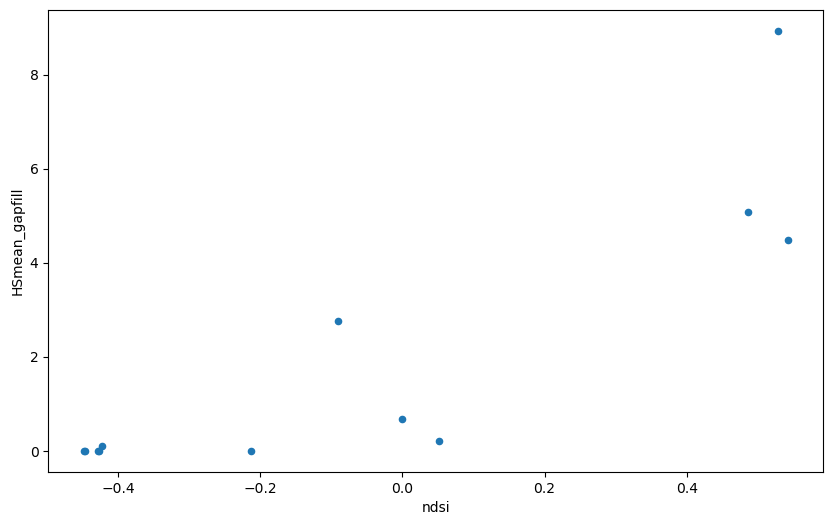

In [44]:
sd_tst.plot.scatter(x = "ndsi", y = "HSmean_gapfill", figsize=(10, 6))

## 5. Processing (not yet loading)

Converting the bounding box we used above to a geodatframe

In [29]:
aoi = box(*bbox)
aoi = gpd.GeoDataFrame({"geometry": [aoi]}, crs="EPSG:4326")

Defining the Sentinel-2 data cube

In [30]:
%%time
bands = ["green", "swir16"] # s2 and ls share the same band names, this allows us to load them together directly.
#bands_s2 = bands+["SCL"] # let's try without cloud masking
#bands_ls = bands+["QA_Pixel"] # let's try without cloud masking

cube_s2 = odc_stac.load(items_s2,
                        geopolygon=aoi.geometry, 
                        groupby='solar_day',
                        chunks={"x": 128, "y": 128, "time": -1}, # maybe add a time chunk?
                        bands=bands
)
cube_s2 # is this lazily loaded?
# how can i check if the object is lazy?

CPU times: user 1min 50s, sys: 2.78 s, total: 1min 53s
Wall time: 1min 50s


<xarray.Dataset> Size: 58GB
Dimensions:      (y: 2362, x: 4868, time: 1257)
Coordinates:
  * y            (y) float64 19kB 5.204e+06 5.204e+06 ... 5.134e+06 5.133e+06
  * x            (x) float64 39kB 6.12e+05 6.12e+05 ... 7.58e+05 7.58e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 10kB 2000-01-02T09:45:25.154075 ... 20...
Data variables:
    green        (time, y, x) uint16 29GB dask.array<chunksize=(1257, 128, 128), meta=np.ndarray>
    swir16       (time, y, x) uint16 29GB dask.array<chunksize=(1257, 128, 128), meta=np.ndarray>

Calculating the ndsi, and scaling the reflectances.

In [31]:
# add tested workflow here!
cube_s2["ndsi"]=(cube_s2.green/10000 - cube_s2.swir16/10000) / (cube_s2.green/10000 + cube_s2.swir16/10000)

In [33]:
# TODO: maybe remove masking 
# masking
#valid = ((cube.SCL == 2) |  # dark area pixels
#         (cube.SCL > 3) &   # vegetation, bare soils, water, unclassified
#         (cube.SCL <= 7) |
#        (cube.SCL == 11)   # snow/ice
#         )
#
#cube = xarray.where(valid, cube, 0)

Subset to keep only the ndsi, we are not interested in the reflectances anymore.

In [132]:
cube_s2 = cube_s2["ndsi"] # drop the other two vars! #cube = cube[["ndsi"]] # Dataset

Plot a quick subset, to check if the ndsi values are within the value range -1 and 1.

In [ ]:
%%time
# plotting a subset
cube_s2.isel(time=slice(None, 2), 
             y=slice(0, 10), # would be nice to get a real station here; y=slice(sd_meta.miny.iloc[0], sd_meta.maxy.iloc[0]), 
             x=slice(0, 10), # would be nice to get a real station here; x=slice(sd_meta.minx.iloc[0], sd_meta.maxx.iloc[0])
            ).plot.imshow(col="time", size=8, aspect=1)

In [62]:
print(cube_s2.rio.crs)  # CRS of xarray data
print(sd_meta.geometry.crs)  # CRS of geometry
#gpd.GeoSeries([geometry], crs="EPSG:4326").to_crs(data.rio.crs)
sd_meta.geometry.to_crs(cube_s2.rio.crs)

EPSG:32632
EPSG:4326


2508    POLYGON ((736549.435 5194558.435, 736554.326 5...
2510    POLYGON ((678386.318 5141925.497, 678391.233 5...
2514    POLYGON ((632542.247 5152258.564, 632547.237 5...
2515    POLYGON ((712313.389 5202627.461, 712318.32 52...
2517    POLYGON ((733385.428 5183196.435, 733390.31 51...
2518    POLYGON ((692401.353 5200125.483, 692406.307 5...
2519    POLYGON ((652649.279 5156378.534, 652654.244 5...
2521    POLYGON ((692435.345 5154318.479, 692440.252 5...
2523    POLYGON ((640788.258 5149974.552, 640793.235 5...
2524    POLYGON ((701137.366 5184095.471, 701142.292 5...
2525    POLYGON ((706284.377 5196303.466, 706289.309 5...
2526    POLYGON ((722915.404 5163204.442, 722920.278 5...
2527    POLYGON ((638312.255 5149415.555, 638317.234 5...
2528    POLYGON ((694945.353 5172111.477, 694950.274 5...
2529    POLYGON ((719151.398 5169265.448, 719156.284 5...
2530    POLYGON ((711316.385 5180743.458, 711321.293 5...
2531    POLYGON ((667233.305 5169657.512, 667238.262 5...
2532    POLYGO

In [77]:
sd_meta_s2 = sd_meta
sd_meta_s2.geometry = sd_meta_s2.geometry.to_crs(cube_s2.rio.crs)
sd_meta_s2.geometry
sd_meta_s2 = sd_meta_s2.drop(['minx', 'miny', 'maxx', 'maxy'], axis=1)
sd_meta_s2 = pd.concat([sd_meta_s2, sd_meta_s2.bounds], axis=1)

In [78]:
sd_meta_s2

,Name,Longitude,Latitude,Elevation,geometry,minx,miny,maxx,maxy
2508,Anterselva_di_Mezzo_Osservatore,12.100897,46.860722,1236.0,"POLYGON ((736549.435 5194558.435, 736554.326 5...",736149.673963,5.194154e+06,736554.325765,5.194558e+06
2510,Bronzolo_Osservatore,11.318249,46.405577,250.0,"POLYGON ((678386.318 5141925.497, 678391.233 5...",677986.767809,5.141521e+06,678391.232539,5.141925e+06
2514,Diga_di_Gioveretto_Osservatore,10.725072,46.509063,1851.0,"POLYGON ((632542.247 5152258.564, 632547.237 5...",632142.763038,5.151853e+06,632547.237116,5.152259e+06
2515,Diga_di_Neves_Osservatore,11.787089,46.941417,1860.0,"POLYGON ((712313.389 5202627.461, 712318.32 52...",711913.680471,5.202223e+06,712318.319849,5.202627e+06
2517,Diga_di_Valdaora_Osservatore,12.053657,46.759737,1057.0,"POLYGON ((733385.428 5183196.435, 733390.31 51...",732985.690037,5.182792e+06,733390.309639,5.183196e+06
2518,Diga_di_Vizze_Osservatore,11.524672,46.924992,1365.0,"POLYGON ((692401.353 5200125.483, 692406.307 5...",692001.693727,5.199721e+06,692406.306549,5.200125e+06
2519,Diga_di_Zoccolo_Osservatore,10.988362,46.541867,1144.0,"POLYGON ((652649.279 5156378.534, 652654.244 5...",652249.756432,5.155973e+06,652654.243675,5.156379e+06
2521,Fie_allo_Sciliar_Osservatore,11.505966,46.513153,835.0,"POLYGON ((692435.345 5154318.479, 692440.252 5...",692035.747657,5.153914e+06,692440.252208,5.154318e+06
2523,Fontana_Bianca,10.831811,46.486847,1900.0,"POLYGON ((640788.258 5149974.552, 640793.235 5...",640388.764913,5.149569e+06,640793.234599,5.149975e+06
2524,Fortezza_Osservatore,11.632246,46.778304,725.0,"POLYGON ((701137.366 5184095.471, 701142.292 5...",700737.708055,5.183691e+06,701142.291695,5.184095e+06


In [79]:
cube_s2.rio.clip([box(sd_meta_s2.minx.iloc[1], 
                      sd_meta_s2.miny.iloc[1], 
                      sd_meta_s2.maxx.iloc[1], 
                      sd_meta_s2.maxy.iloc[1])], 
                 all_touched=True)

<xarray.DataArray 'ndsi' (time: 161, y: 41, x: 42)> Size: 2MB
dask.array<getitem, shape=(161, 41, 42), dtype=float64, chunksize=(12, 41, 42), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 328B 5.142e+06 5.142e+06 ... 5.142e+06 5.142e+06
  * x            (x) float64 336B 6.78e+05 6.78e+05 ... 6.784e+05 6.784e+05
  * time         (time) datetime64[ns] 1kB 2015-07-04T10:10:06.027000 ... 201...
    spatial_ref  int64 8B 0

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 98.63 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


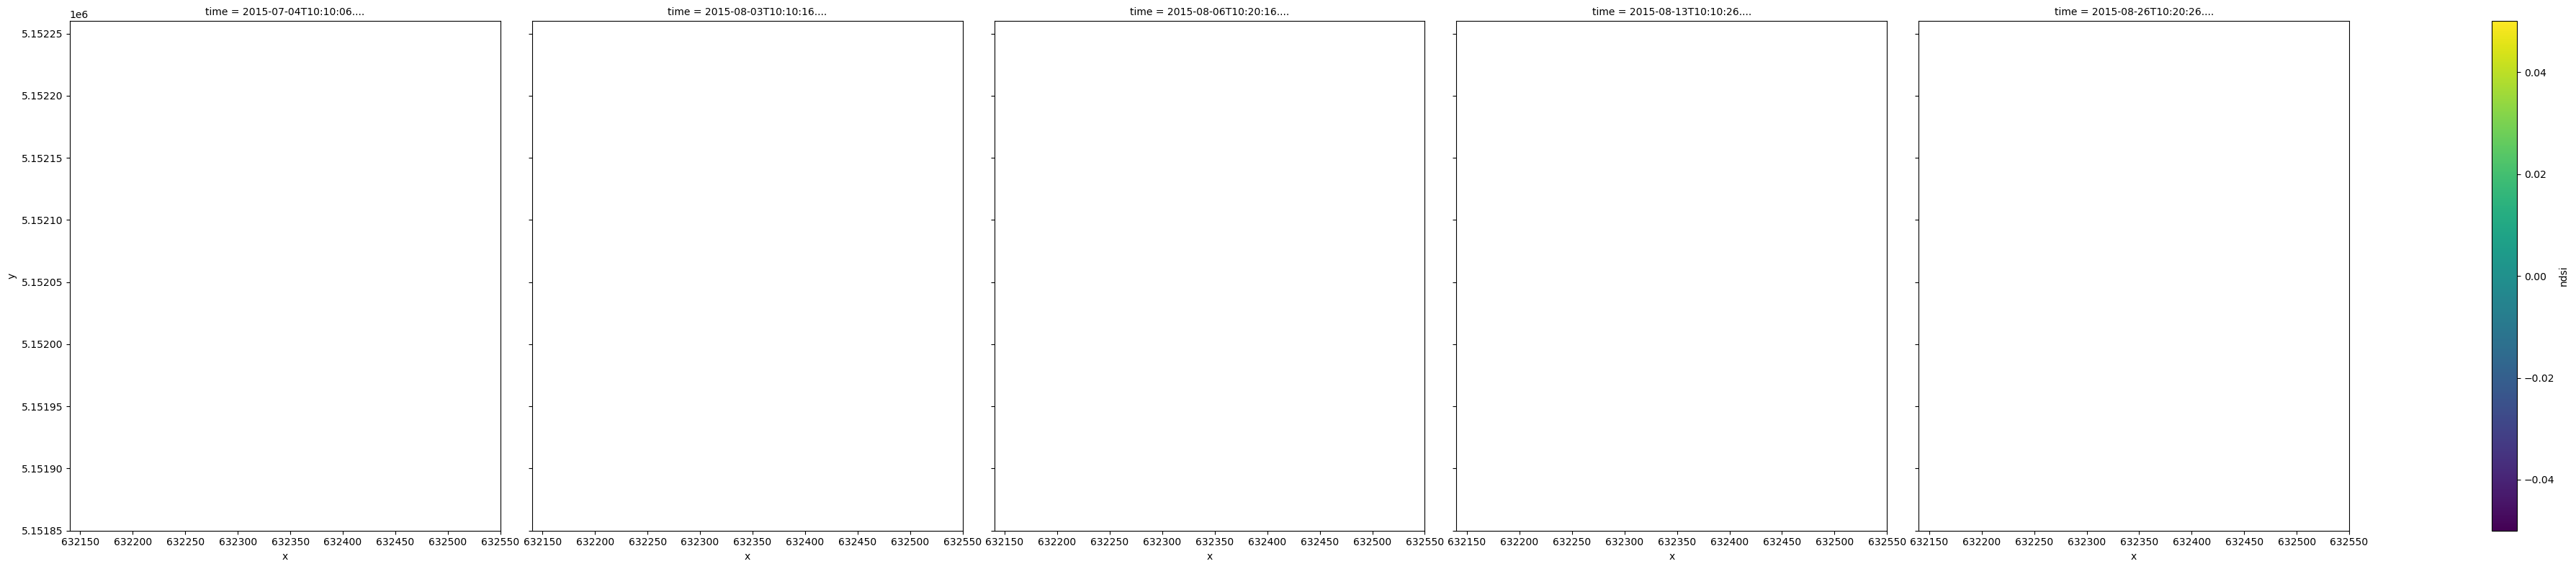

In [83]:
cube_s2.rio.clip([box(sd_meta_s2.minx.iloc[2], 
                      sd_meta_s2.miny.iloc[2], 
                      sd_meta_s2.maxx.iloc[2], 
                      sd_meta_s2.maxy.iloc[2])], 
                 all_touched=True).isel(time=slice(None, 5)).plot.imshow(col="time", size=8, aspect=1)

In [100]:
cube_s2.rio.clip([box(sd_meta_s2.minx.iloc[2], 
                      sd_meta_s2.miny.iloc[2], 
                      sd_meta_s2.maxx.iloc[2], 
                      sd_meta_s2.maxy.iloc[2])], 
                 all_touched=True).isel(time=slice(None, 5)).load()

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 98.63 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


<xarray.DataArray 'ndsi' (time: 5, y: 41, x: 41)> Size: 67kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * y            (y) float64 328B 5.152e+06 5.152e+06 ... 5.152e+06 5.152e+06
  * x            (x) float64 328B 6.321e+05 6.322e+05 ... 6.325e+05 6.325e+05
  * time         (time) datetime64[ns] 40B 2015-07-04T10:10:06.027000 ... 201...
    spatial_ref  int64 8B 0

In [36]:
# spatial aggregation -> this was for one station 
# cube_s2_agg = cube_s2.mean(dim=["x", "y"])

In [36]:
cube_s2

<xarray.DataArray 'ndsi' (time: 161, y: 7083, x: 14601)> Size: 133GB
dask.array<truediv, shape=(161, 7083, 14601), dtype=float64, chunksize=(12, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 57kB 5.204e+06 5.204e+06 ... 5.134e+06 5.133e+06
  * x            (x) float64 117kB 6.12e+05 6.12e+05 ... 7.58e+05 7.58e+05
    spatial_ref  int32 4B 32632
  * time         (time) datetime64[ns] 1kB 2015-07-04T10:10:06.027000 ... 201...

In [119]:
# temporal maximum value composite
cube_s2_mnth = cube_s2.resample(time="1ME").max().chunk(chunks={'time': -1})

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/array/core.py:5028: PerformanceWarning: Increasing number of chunks by factor of 54
  result = blockwise(
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/array/core.py:5028: PerformanceWarning: Increasing number of chunks by factor of 115
  result = blockwise(


In [120]:
cube_s2_mnth

<xarray.DataArray 'ndsi' (time: 54, y: 7083, x: 14601)> Size: 45GB
dask.array<rechunk-merge, shape=(54, 7083, 14601), dtype=float64, chunksize=(54, 128, 128), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 57kB 5.204e+06 5.204e+06 ... 5.134e+06 5.133e+06
  * x            (x) float64 117kB 6.12e+05 6.12e+05 ... 7.58e+05 7.58e+05
  * time         (time) datetime64[ns] 432B 2015-07-31 2015-08-31 ... 2019-12-31
    spatial_ref  int32 4B 32632

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 98.66 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


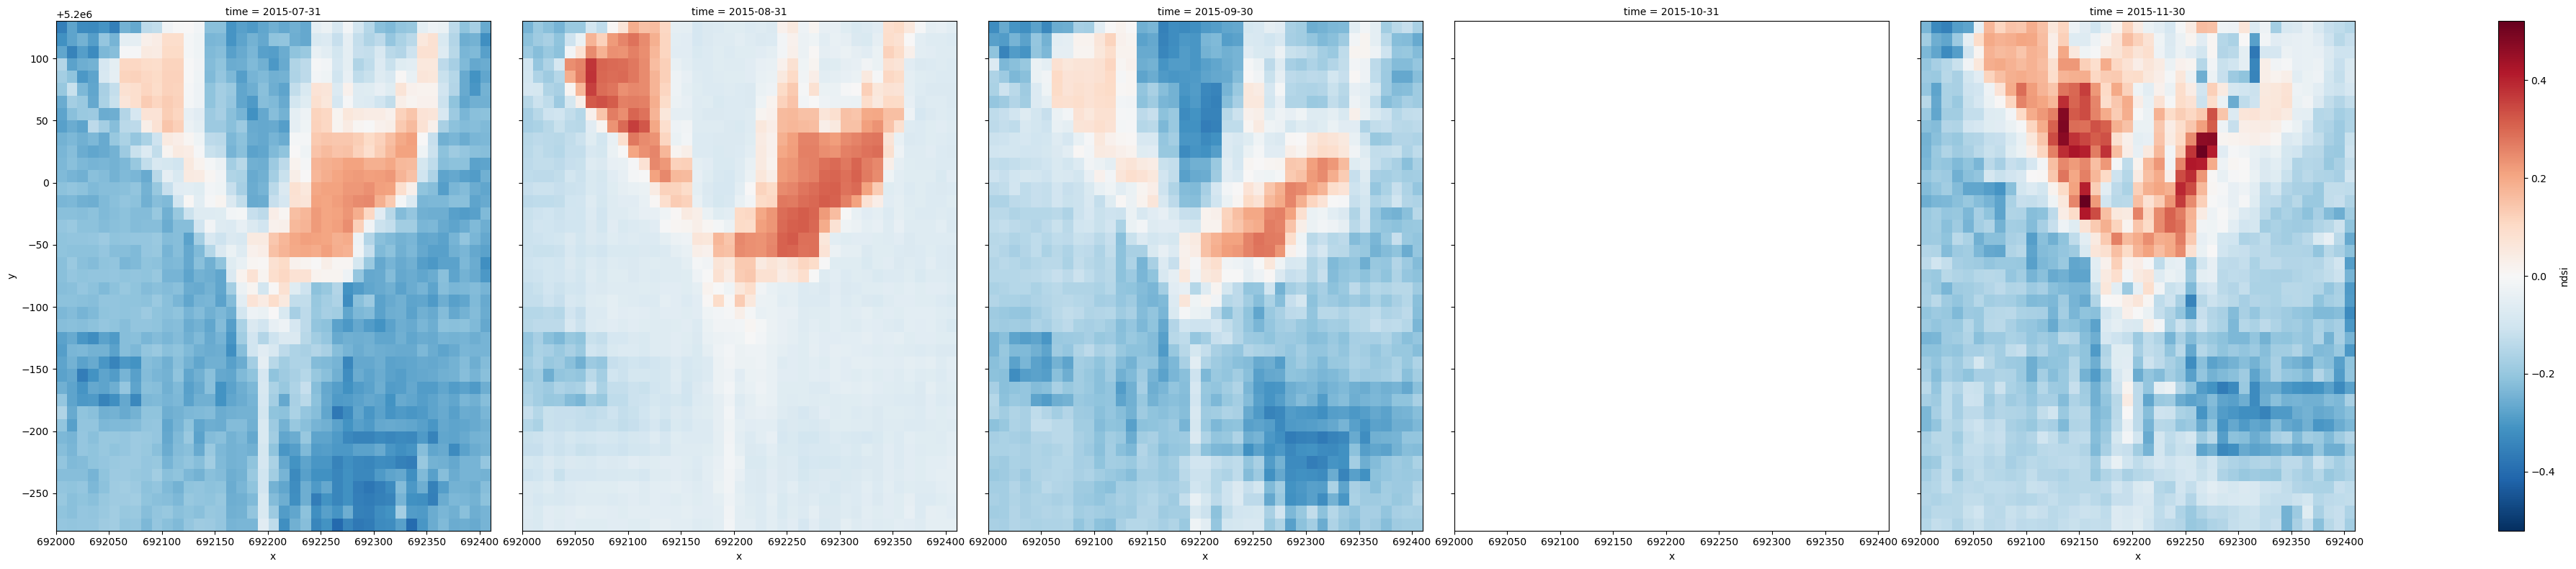

In [105]:
cube_s2_mnth.rio.clip([box(sd_meta_s2.minx.iloc[5], 
                           sd_meta_s2.miny.iloc[5], 
                           sd_meta_s2.maxx.iloc[5], 
                           sd_meta_s2.maxy.iloc[5])], 
                      all_touched=True).isel(time=slice(None, 5)).plot.imshow(col="time", size=8, aspect=1)

In [40]:
type(list(sd_meta.geometry[0:3]))

list

In [121]:
# TODO: xvec
# extract points :D
#cube_s2
#sd_meta.geometry
cube_s2_zonal = cube_s2_mnth.isel(time=slice(None, 5)).xvec.zonal_stats(
    list(sd_meta_s2.geometry[0:5]), x_coords="x", y_coords="y", stats="max", 
    method="iterate",
    n_jobs=-1,
)

cube_s2_zonal

<xarray.DataArray 'ndsi' (geometry: 5, time: 5)> Size: 200B
dask.array<concatenate, shape=(5, 5), dtype=float64, chunksize=(1, 5), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 40B 2015-07-31 2015-08-31 ... 2015-11-30
    spatial_ref  int32 4B 32632
  * geometry     (geometry) object 40B POLYGON ((736549.4353757619 5194558.43...
Indexes:
    geometry  GeometryIndex (crs=None)

In [112]:
cube_s2_zonal

/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 493.80 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/dss/dsshome1/06/di38laz/micromamba/envs/prepml/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)

In [113]:
tst

<xarray.DataArray 'ndsi' (geometry: 5, time: 5)> Size: 200B
array([[ 0.10559751,  0.21697076, -0.03080651,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan],
       [ 0.13596024,  0.2199479 ,  0.21392678,         nan,  0.13614263],
       [        nan,         nan,         nan,         nan,         nan]])
Coordinates:
  * time         (time) datetime64[ns] 40B 2015-07-31 2015-08-31 ... 2015-11-30
    spatial_ref  int32 4B 32632
  * geometry     (geometry) object 40B POLYGON ((736549.4353757619 5194558.43...
Indexes:
    geometry  GeometryIndex (crs=None)

In [94]:
(
    tst
    .sel(time='2015-07-31T00:00:00.000000000')
    .xvec.to_geodataframe(geometry="geometry")
    .explore()
)

In [ ]:
(
    cube_s2_zonal
    .sel(time='2015-07-31T00:00:00.000000000')
    .xvec.to_geodataframe(geometry="geometry")
    .explore("ndsi")
)

In [ ]:
cube_s2_zonal.plot.imshow(col="time", size=8, aspect=1)

In [ ]:
cube_agg_mnth

CPU times: user 30 ms, sys: 7.77 ms, total: 37.7 ms
Wall time: 36.2 ms


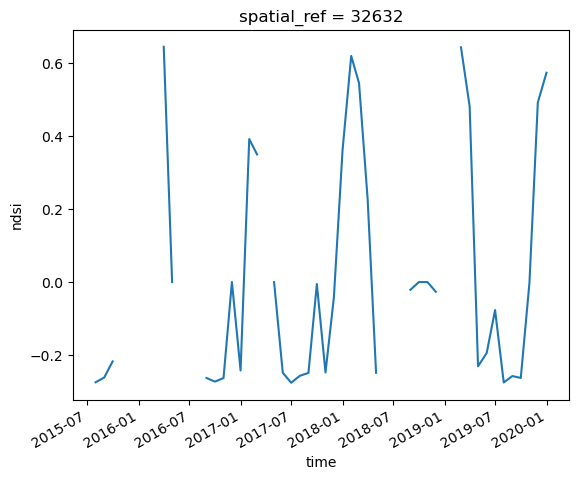

In [36]:
%%time
cube_agg_mnth.plot()

### LS Cubes

In [114]:
del tst

In [115]:
tst

NameError: name 'tst' is not defined

In [37]:
%%time
cube_ls = odc_stac.load(filtered_items['landsat-ot-c2-l2']['items'],
                        #filtered_items['landsat-etm-c2-l2']['items'],
                        #filtered_items['landsat-tm-c2-l2']['items'],
                         geopolygon=sd_meta.iloc[0].geometry, # i want the according geoms here
                         groupby='solar_day',
                         #bbox=sd_meta.iloc[0],
                         #chunks={"time": 100, "x": 7, "y": 7},
                         #chunks={'x': dask_chunksize, 'y': dask_chunksize},  # spatial chunking
                         #anchor=geobox.AnchorEnum.FLOATING,  # preserve original pixel grid
                         bands=filtered_items['landsat-ot-c2-l2']['bands']
)
cube_ls # is this lazily loaded?
#cube_ls.delete()
# del cube_ls

CPU times: user 3.69 s, sys: 1.18 s, total: 4.88 s
Wall time: 38.9 s


<xarray.Dataset>
Dimensions:      (y: 14, x: 14, time: 118)
Coordinates:
  * y            (y) float64 5.195e+06 5.195e+06 ... 5.194e+06 5.194e+06
  * x            (x) float64 7.362e+05 7.362e+05 ... 7.365e+05 7.365e+05
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2013-04-13T10:00:09.937583 ... 2019-12...
Data variables:
    green        (time, y, x) uint16 12298 11561 10272 10154 ... 7702 8857 9190
    swir16       (time, y, x) uint16 18413 17727 16064 15266 ... 6473 6480 6564
    QA_Pixel     (time, y, x) uint16 22280 22280 22018 ... 21952 21952 21952

In [38]:
# ndsi
cube_ls["ndsi"]=(cube_ls.green/10000 - cube_ls.swir16/10000) / (cube_ls.green/10000 + cube_ls.swir16/10000)

In [39]:
# masking!

In [40]:
cube_ls = cube_ls["ndsi"] # drop the other two vars! #cube = cube[["ndsi"]] # Dataset

In [41]:
cube_ls_agg = cube_ls.mean(dim=["x", "y"])

In [42]:
cube_ls_agg

<xarray.DataArray 'ndsi' (time: 118)>
array([-0.16472989,  0.10718255, -0.18491238, -0.04018157, -0.1823381 ,
       -0.06518389, -0.19717921,         nan, -0.05827565,         nan,
               nan,         nan, -0.12545052,         nan, -0.19992076,
               nan,         nan, -0.20833719,  0.20244799, -0.14310602,
       -0.18576206, -0.20773338,         nan, -0.15096174, -0.13033849,
               nan, -0.17614499, -0.20109051,         nan, -0.20847263,
        0.00276946,  0.09448408,         nan,         nan, -0.15341447,
       -0.22683406, -0.19572319, -0.20500362,         nan,         nan,
               nan,  0.38775747,         nan,  0.52195555,         nan,
        0.24784022, -0.09715567, -0.18856369, -0.19723273, -0.19874863,
       -0.09190465, -0.20956773, -0.03519754, -0.13895264, -0.2116649 ,
        0.39893811, -0.08629789,         nan, -0.14003849, -0.16350188,
        0.39744273,  0.09379541,         nan, -0.20291865,  0.08112397,
        0.0209384 , -0.17855299, -0.18091753, -0.19328905,         nan,
       -0.20976961, -0.15803375, -0.18817948, -0.19320989, -0.17282546,
       -0.17904471,  0.5026663 ,  0.57473186,         nan,         nan,
        0.13034769,         nan, -0.02570413,         nan,  0.06405163,
       -0.22147864, -0.22788301, -0.20467227, -0.18728627, -0.19312348,
       -0.18860982, -0.19424615,         nan, -0.20036796,         nan,
               nan,  0.62253915,  0.57989881,         nan,  0.26267288,
               nan, -0.2005176 ,         nan,         nan, -0.15887422,
               nan, -0.20420343,  0.19657085, -0.19033995, -0.17169101,
        0.09955687, -0.18623292, -0.04794856, -0.1958404 , -0.18102045,
        0.50832569,  0.17308741,  0.5434882 ])
Coordinates:
    spatial_ref  int32 32632
  * time         (time) datetime64[ns] 2013-04-13T10:00:09.937583 ... 2019-12...

In [43]:
# temporal maximum value composite
cube_ls_agg_mnth = cube_ls_agg.resample(time="1ME").max()

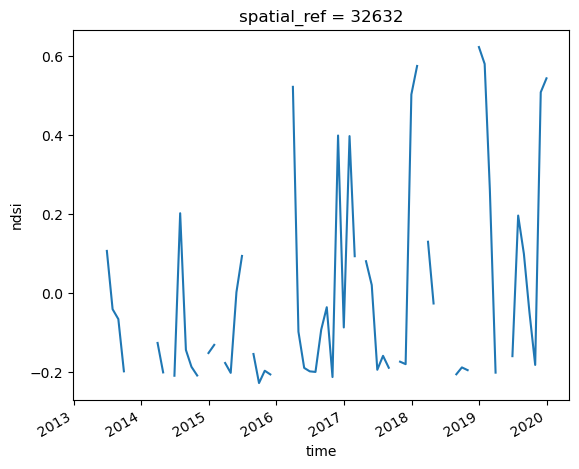

In [44]:
cube_ls_agg_mnth.plot()

In [45]:
cube_agg_merged = cube_agg.to_dataset().merge(other = cube_ls_agg.to_dataset())

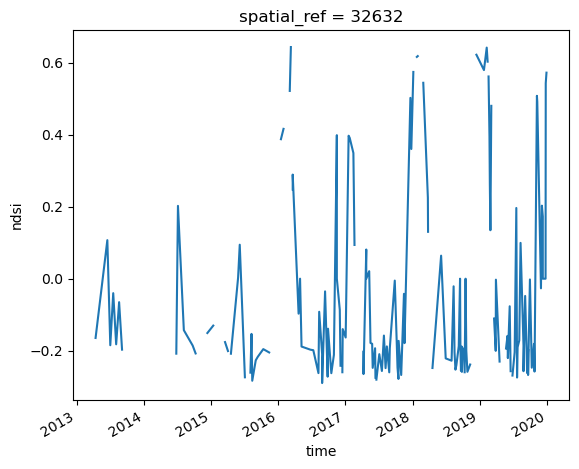

In [46]:
cube_agg_merged['ndsi'].plot()

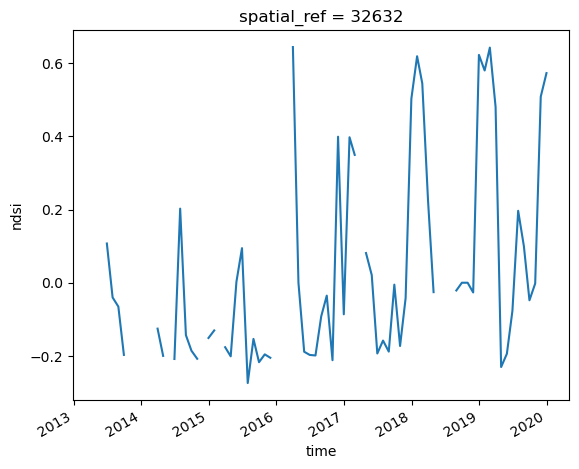

In [47]:
cube_agg_merged_mnth = cube_agg_merged.resample(time="1ME").max()
cube_agg_merged_mnth['ndsi'].plot()

In [ ]:
# lazy loading 
# reduce everything unnecessary
# QA needed?
# merge after aggregating spatially, then aggregate temporally
# do it for all stations! 
# a) load whole region, select stations via xvec later
# b) load explicitly station geoms

In [70]:
print(cube_agg_merged_mnth)

<xarray.Dataset>
Dimensions:      (time: 81)
Coordinates:
  * time         (time) datetime64[ns] 2013-04-30 2013-05-31 ... 2019-12-31
    spatial_ref  int32 32632
Data variables:
    ndsi         (time) float64 -0.1647 nan 0.1072 ... -0.002122 0.5083 0.5727


In [61]:
cube_agg_merged_mnth['ndsi'].time.min()
cube_agg_merged_mnth['ndsi'].time.max()


<xarray.DataArray 'time' ()>
array('2019-12-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 32632

In [66]:
sd_mnth['time'] = pd.to_datetime(sd_mnth['year'].astype(str) + '-' + sd_mnth['month'].astype(str)) + pd.offsets.MonthEnd(0)

108     2000-01-31
109     2000-02-29
110     2000-03-31
111     2000-04-30
112     2000-05-31
           ...    
29395   2017-08-31
29396   2017-09-30
29397   2017-10-31
29398   2017-11-30
29399   2017-12-31
Name: time, Length: 14592, dtype: datetime64[ns]

In [64]:
sd_mnth['time']

108     2000-01-01
109     2000-01-01
110     2000-01-01
111     2000-01-01
112     2000-01-01
           ...    
29395   2000-01-01
29396   2000-01-01
29397   2000-01-01
29398   2000-01-01
29399   2000-01-01
Name: time, Length: 14592, dtype: datetime64[ns]

In [73]:
ndsi_mnth = cube_agg_merged_mnth.to_dataframe()
ndsi_mnth

,spatial_ref,ndsi
time,,
2013-04-30,32632,-0.164730
2013-05-31,32632,NaN
2013-06-30,32632,0.107183
2013-07-31,32632,-0.040182
2013-08-31,32632,-0.065184
...,...,...
2019-08-31,32632,0.099557
2019-09-30,32632,-0.047949
2019-10-31,32632,-0.002122


In [72]:
sd_mnth[(sd_mnth['Name']==sd_meta.Name.iloc[0]) & 
    (sd_mnth['time']>=cube_agg_merged_mnth['ndsi'].time.min().values) & 
    (sd_mnth['time']<=cube_agg_merged_mnth['ndsi'].time.max().values)]

,Name,year,month,HSmean_gapfill,time
1287,Anterselva_di_Mezzo_Osservatore,2013,4,0.300000,2013-04-30
1288,Anterselva_di_Mezzo_Osservatore,2013,5,0.096774,2013-05-31
1289,Anterselva_di_Mezzo_Osservatore,2013,6,0.000000,2013-06-30
1290,Anterselva_di_Mezzo_Osservatore,2013,7,0.000000,2013-07-31
1291,Anterselva_di_Mezzo_Osservatore,2013,8,0.000000,2013-08-31
...,...,...,...,...,...
1363,Anterselva_di_Mezzo_Osservatore,2019,8,0.000000,2019-08-31
1364,Anterselva_di_Mezzo_Osservatore,2019,9,0.000000,2019-09-30
1365,Anterselva_di_Mezzo_Osservatore,2019,10,NaN,2019-10-31
1366,Anterselva_di_Mezzo_Osservatore,2019,11,NaN,2019-11-30


In [78]:
sd_ndsi_mnth = pd.merge(sd_mnth[(sd_mnth['Name']==sd_meta.Name.iloc[0])], ndsi_mnth, on = "time")

In [79]:
sd_ndsi_mnth

,Name,year,month,HSmean_gapfill,time,spatial_ref,ndsi
0,Anterselva_di_Mezzo_Osservatore,2013,4,0.300000,2013-04-30,32632,-0.164730
1,Anterselva_di_Mezzo_Osservatore,2013,5,0.096774,2013-05-31,32632,NaN
2,Anterselva_di_Mezzo_Osservatore,2013,6,0.000000,2013-06-30,32632,0.107183
3,Anterselva_di_Mezzo_Osservatore,2013,7,0.000000,2013-07-31,32632,-0.040182
4,Anterselva_di_Mezzo_Osservatore,2013,8,0.000000,2013-08-31,32632,-0.065184
...,...,...,...,...,...,...,...
76,Anterselva_di_Mezzo_Osservatore,2019,8,0.000000,2019-08-31,32632,0.099557
77,Anterselva_di_Mezzo_Osservatore,2019,9,0.000000,2019-09-30,32632,-0.047949
78,Anterselva_di_Mezzo_Osservatore,2019,10,NaN,2019-10-31,32632,-0.002122
79,Anterselva_di_Mezzo_Osservatore,2019,11,NaN,2019-11-30,32632,0.508326


<Axes: xlabel='ndsi', ylabel='HSmean_gapfill'>

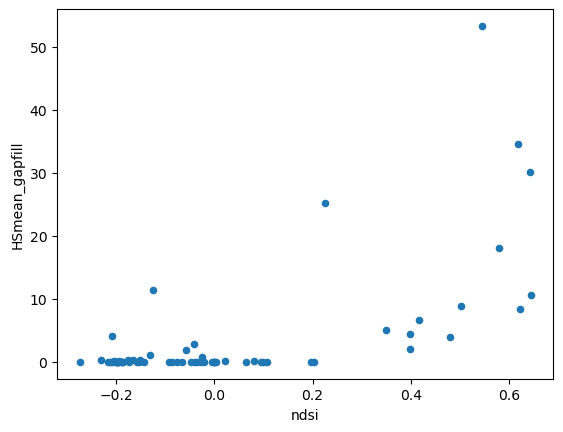

In [80]:
sd_ndsi_mnth.plot.scatter(x = "ndsi", y = "HSmean_gapfill")

ModuleNotFoundError: No module named 'seaborn'

In [85]:
import sklearn


## Outlook

Next steps in this workflow could be:
- Test an example where the stations are spread out over the globe.
- Include cloud and quality maksing to get more robust results.
- Use static information like elevation, aspect etc.
- Apply more sophisticated machine learning:
    - Time series prediction (extrapolation in time)
    - Mapping (extrapolation in space)
- Add more features (e.g. [ERA5](https://earthdatahub.destine.eu/tutorials/tutorial-era5-land-floods-precipitation-anomaly-in-greece?came_from=https%3A%2F%2Flnkd.in%2F)) and do a mulitvariate analysis.